In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import haversine_distances

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    cat_num = 100
    feat_columns = ['name', 'address', 'city', 
                'state', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):
    latlon_values = data.loc[df['id'], ['latitude', 'longitude']].values
    matlatlon_values = data.loc[df['match_id'], ['latitude', 'longitude']].values
    distances = []
    cnt = 0
    for latlon, matlatlon in tqdm(zip(latlon_values, matlatlon_values)):
        distances.append(haversine_distances([latlon, matlatlon])[0, 1])

        cnt += 1
        if cnt % 1000000 == 0:
            gc.collect()
    
    df['distance'] = distances

    del latlon_values, matlatlon_values, distances
    gc.collect()

    cat_values = data.loc[df['id']]['categories'].values.astype(str)
    matcat_values = data.loc[df['match_id']]['categories'].values.astype(str)
    cat_dist_percentile1 = []
    cat_dist_percentile2 = []

    cat2dist_distances_num = cat2dist['distances_num'].values
    cat2dist_distances = cat2dist['distances'].values
    cat2idx = {cat:i for i, cat in enumerate(cat2dist.index)}

    cnt = 0
    for s, distance in tqdm(zip(cat_values, df['distance'].values)):
        min_cat = 'unknown'
        min_cat_num = float('inf')
        for cat in s.split(', '):
            if cat != 'nan' and cat in categories:
                cat_num = cat2dist_distances_num[cat2idx[cat]]
                if CFG.cat_num <= cat_num < min_cat_num:
                    min_cat_num = cat_num
                    min_cat = cat
        cat_distances = cat2dist_distances[cat2idx[min_cat]]
        cat_dist_percentile1.append((cat_distances < distance).astype(int).mean())

        cnt += 1
        if cnt % 1000000 == 0:
            gc.collect()

    gc.collect()
    
    cnt = 0
    for s, distance in tqdm(zip(matcat_values, df['distance'].values)):
        min_cat = 'unknown'
        min_cat_num = float('inf')
        for cat in s.split(', '):
            if cat != 'nan' and cat in categories:
                cat_num = cat2dist_distances_num[cat2idx[cat]]
                if CFG.cat_num <= cat_num < min_cat_num:
                    min_cat_num = cat_num
                    min_cat = cat
        cat_distances = cat2dist_distances[cat2idx[min_cat]]
        cat_dist_percentile2.append((cat_distances < distance).astype(int).mean())

        cnt += 1
        if cnt % 1000000 == 0:
            gc.collect()
    
    gc.collect()

    df['cat_dist_percentile1'] = cat_dist_percentile1
    df['cat_dist_percentile2'] = cat_dist_percentile2

    del cat_values, matcat_values, cat_dist_percentile1, cat_dist_percentile2, cat2dist_distances_num, cat2dist_distances
    gc.collect()

    for col in tqdm(CFG.feat_columns):
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        vc = data[col].value_counts()
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
        gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

Calculate distances between matched entities

In [ ]:
cat2dis_data = data[data['set'] == 0]

In [ ]:
poi2distances = {}
all_distances = []
for poi, df in tqdm(cat2dis_data[["latitude", "longitude", "point_of_interest"]].groupby("point_of_interest"),
                    total=cat2dis_data["point_of_interest"].nunique()):
    if len(df) == 1:
        # no matches
        continue
        
    distances = []
    distances_mat = haversine_distances(df[["latitude", "longitude"]].values)
    for i in range(len(df) - 1):
        for j in range(i + 1, len(df)):
            # haversine distance -> meters
            distances.append(distances_mat[i, j])
            all_distances.append(distances_mat[i, j])
    poi2distances[poi] = distances

  0%|          | 0/369986 [00:00<?, ?it/s]

In [ ]:
poi2distances_df = pd.DataFrame({
    "point_of_interest": list(poi2distances.keys()),
    "distances": list(poi2distances.values())
})
poi2distances_df.head()

,point_of_interest,distances
0,P_0000c58a53df6d,[0.002288377953984225]
1,P_00010455487fcf,[0.0004857766987403706]
2,P_000116a2d0a467,[0.0003377296227570637]
3,P_00019fb954100b,[0.016459019668901686]
4,P_00027058a58996,[0.00028316048697444137]


Split categories, merge with distances per point_of_interest

In [ ]:
cat2dis_data["categories"] = cat2dis_data["categories"].fillna("").map(lambda x: x.split(", "))
cat2dis_data_ = cat2dis_data[["id", "name", "categories", "point_of_interest"]].merge(
    poi2distances_df, on="point_of_interest", how="inner")
cat2dis_data_["median_distances"] = cat2dis_data_["distances"].map(np.median)
cat2dis_data_.head()

,id,name,categories,point_of_interest,distances,median_distances
0,E_000002eae2a589,Carioca Manero,[Brazilian Restaurants],P_d82910d8382a83,[0.0002270160308670873],0.000227
1,E_e80db432029aea,Carioca Manero,"[Bars, Snack Places]",P_d82910d8382a83,[0.0002270160308670873],0.000227
2,E_000023d8f4be44,Island Spa,[Spas],P_020de174484ec6,[0.0007648195740532826],0.000765
3,E_12453effe251db,Island Spa Theater,[Spas],P_020de174484ec6,[0.0007648195740532826],0.000765
4,E_0000d9e584ed9f,Signature Properties Savannah,[Real Estate Offices],P_af856e3abdcebc,[0.00463056196777935],0.004631


Aggregate distances for each categories

In [ ]:
# make each row has only one category
exploded = cat2dis_data_.explode("categories").drop_duplicates(["point_of_interest", "categories"])
exploded.head()

,id,name,categories,point_of_interest,distances,median_distances
0,E_000002eae2a589,Carioca Manero,Brazilian Restaurants,P_d82910d8382a83,[0.0002270160308670873],0.000227
1,E_e80db432029aea,Carioca Manero,Bars,P_d82910d8382a83,[0.0002270160308670873],0.000227
1,E_e80db432029aea,Carioca Manero,Snack Places,P_d82910d8382a83,[0.0002270160308670873],0.000227
2,E_000023d8f4be44,Island Spa,Spas,P_020de174484ec6,[0.0007648195740532826],0.000765
4,E_0000d9e584ed9f,Signature Properties Savannah,Real Estate Offices,P_af856e3abdcebc,[0.00463056196777935],0.004631


In [ ]:
cat2dist = exploded.groupby("categories")['distances'].apply(lambda x: np.array(list(itertools.chain.from_iterable(x))))
cat2dist = cat2dist.reset_index()
cat2dist.loc[0, 'categories'] = 'unknown'
cat2dist['distances'][0] = np.array(all_distances)
cat2dist['distances_num'] = cat2dist['distances'].map(len)

In [ ]:
cat2dist.head()

,categories,distances,distances_num
0,unknown,"[0.002288377953984225, 0.0004857766987403706, ...",488144
1,ATMs,"[0.0, 0.0005935208131384233, 0.008514918716458...",1231
2,Acai Houses,"[0.001365053899785685, 0.021202317098512818, 0...",14
3,Accessories Stores,"[8.001115039381182e-06, 0.11833767331271419, 0...",634
4,Acehnese Restaurants,"[0.0011796681951925748, 0.00016238913050424747...",110


In [ ]:
del cat2dis_data, cat2dis_data_, poi2distances_df, exploded
gc.collect()

200

In [ ]:
categories = set(cat2dist['categories'])
cat2dist = cat2dist.set_index('categories')

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
features = ['distance', 'cat_dist_percentile1', 'cat_dist_percentile2', 'kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

63
['distance', 'cat_dist_percentile1', 'cat_dist_percentile2', 'kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'categories_CE_1', 'categories_CE_2'

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0424161
[100]	valid_0's binary_logloss: 0.0397828
[150]	valid_0's binary_logloss: 0.0387204
[200]	valid_0's binary_logloss: 0.0378814
[250]	valid_0's binary_logloss: 0.0374002
[300]	valid_0's binary_logloss: 0.036877
[350]	valid_0's binary_logloss: 0.0365208
[400]	valid_0's binary_logloss: 0.0361234
[450]	valid_0's binary_logloss: 0.0358397
[500]	valid_0's binary_logloss: 0.0355838
[550]	valid_0's binary_logloss: 0.0353117
[600]	valid_0's binary_logloss: 0.0350892
[650]	valid_0's binary_logloss: 0.0348821
[700]	valid_0's binary_logloss: 0.0346987
[750]	valid_0's binary_logloss: 0.0345528
[800]	valid_0's binary_logloss: 0.0343894
[850]	valid_0's binary_logloss: 0.0342321
[900]	valid_0's binary_logloss: 0.0340457
[950]	valid_0's binary_logloss: 0.0339007
[1000]	valid_0's binary_logloss: 0.0337386
[1050]	valid_0's binary_logloss: 0.0336116
[1100]	valid_0's binary_logloss: 0.033483
[1150]	valid_0's binary_logloss: 0.0333467
[1200]	valid_0's binary_logloss: 

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

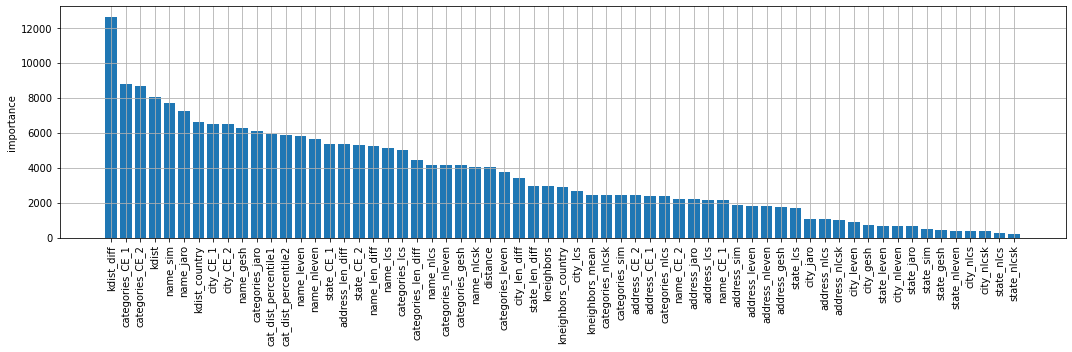

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-29 10:15:45,677] A new study created in memory with name: no-name-9441b89f-1459-42a8-9ec8-ea3731c86003
[I 2022-05-29 10:16:10,439] Trial 0 finished with value: 0.8380266064896331 and parameters: {'threshold': 0.3980603146941867}. Best is trial 0 with value: 0.8380266064896331.


CV: 0.838027


[I 2022-05-29 10:16:30,075] Trial 1 finished with value: 0.8414101661336645 and parameters: {'threshold': 0.5125283883005871}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.841410


[I 2022-05-29 10:16:49,701] Trial 2 finished with value: 0.8077950919763661 and parameters: {'threshold': 0.14881966181233064}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.807795


[I 2022-05-29 10:17:08,383] Trial 3 finished with value: 0.8411400849132668 and parameters: {'threshold': 0.49632134978875453}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.841140


[I 2022-05-29 10:17:29,948] Trial 4 finished with value: 0.7421376868867892 and parameters: {'threshold': 0.04141367534311591}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.742138


[I 2022-05-29 10:17:48,769] Trial 5 finished with value: 0.8396881272722316 and parameters: {'threshold': 0.4391470907741283}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.839688


[I 2022-05-29 10:18:09,442] Trial 6 finished with value: 0.8302378164007732 and parameters: {'threshold': 0.8241778045146924}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.830238


[I 2022-05-29 10:18:28,212] Trial 7 finished with value: 0.837451982677784 and parameters: {'threshold': 0.7361808198450643}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.837452


[I 2022-05-29 10:18:47,008] Trial 8 finished with value: 0.8406612764156435 and parameters: {'threshold': 0.47185338278547406}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.840661


[I 2022-05-29 10:19:06,475] Trial 9 finished with value: 0.8342551720674459 and parameters: {'threshold': 0.7824383781542001}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.834255


[I 2022-05-29 10:19:25,815] Trial 10 finished with value: 0.8222220166085547 and parameters: {'threshold': 0.2184537996892611}. Best is trial 1 with value: 0.8414101661336645.


CV: 0.822222


[I 2022-05-29 10:19:44,541] Trial 11 finished with value: 0.8416641238559012 and parameters: {'threshold': 0.5493024223672197}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841664


[I 2022-05-29 10:20:04,289] Trial 12 finished with value: 0.840973965942455 and parameters: {'threshold': 0.640391912943799}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.840974


[I 2022-05-29 10:20:21,695] Trial 13 finished with value: 0.708827778030614 and parameters: {'threshold': 0.9976475496188834}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.708828


[I 2022-05-29 10:20:40,672] Trial 14 finished with value: 0.834097391925458 and parameters: {'threshold': 0.3276267077102122}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.834097


[I 2022-05-29 10:21:00,267] Trial 15 finished with value: 0.8415613926289998 and parameters: {'threshold': 0.6065201777531225}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841561


[I 2022-05-29 10:21:18,953] Trial 16 finished with value: 0.840089110411243 and parameters: {'threshold': 0.6732879368101023}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.840089


[I 2022-05-29 10:21:38,514] Trial 17 finished with value: 0.8411761220617522 and parameters: {'threshold': 0.6310003114034518}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841176


[I 2022-05-29 10:21:56,608] Trial 18 finished with value: 0.8115542992774065 and parameters: {'threshold': 0.918697955029234}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.811554


[I 2022-05-29 10:22:17,121] Trial 19 finished with value: 0.8416129760235862 and parameters: {'threshold': 0.559984965177062}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841613


[I 2022-05-29 10:22:36,142] Trial 20 finished with value: 0.8327554261417373 and parameters: {'threshold': 0.3083551419455561}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.832755


[I 2022-05-29 10:22:55,806] Trial 21 finished with value: 0.8416421916574024 and parameters: {'threshold': 0.5556039143245571}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841642


[I 2022-05-29 10:23:15,735] Trial 22 finished with value: 0.8416265312096778 and parameters: {'threshold': 0.551454854325401}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841627


[I 2022-05-29 10:23:34,691] Trial 23 finished with value: 0.8367193185163152 and parameters: {'threshold': 0.37160661786384}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.836719


[I 2022-05-29 10:23:53,160] Trial 24 finished with value: 0.8386826469911761 and parameters: {'threshold': 0.7108670383141045}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.838683


[I 2022-05-29 10:24:11,732] Trial 25 finished with value: 0.8416446876076218 and parameters: {'threshold': 0.5664441344544444}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841645


[I 2022-05-29 10:24:30,904] Trial 26 finished with value: 0.8250570681291043 and parameters: {'threshold': 0.8627902127923555}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.825057


[I 2022-05-29 10:24:50,668] Trial 27 finished with value: 0.8416274311123335 and parameters: {'threshold': 0.557317001504228}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841627


[I 2022-05-29 10:25:09,940] Trial 28 finished with value: 0.8228914932969642 and parameters: {'threshold': 0.22230577757702963}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.822891


[I 2022-05-29 10:25:28,672] Trial 29 finished with value: 0.8394564691946849 and parameters: {'threshold': 0.43244728333006704}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.839456


[I 2022-05-29 10:25:47,586] Trial 30 finished with value: 0.8369946247890372 and parameters: {'threshold': 0.37548236278698466}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.836995


[I 2022-05-29 10:26:07,090] Trial 31 finished with value: 0.841648912765333 and parameters: {'threshold': 0.5655574678178203}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841649


[I 2022-05-29 10:26:28,403] Trial 32 finished with value: 0.8414321782800837 and parameters: {'threshold': 0.5163687934257618}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841432


[I 2022-05-29 10:26:47,044] Trial 33 finished with value: 0.8415911343069389 and parameters: {'threshold': 0.6027822985298235}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841591


[I 2022-05-29 10:27:05,600] Trial 34 finished with value: 0.8388619998820976 and parameters: {'threshold': 0.7069010152061143}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.838862


[I 2022-05-29 10:27:24,262] Trial 35 finished with value: 0.840985880852236 and parameters: {'threshold': 0.4866689929278454}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.840986


[I 2022-05-29 10:27:44,007] Trial 36 finished with value: 0.8392663527486783 and parameters: {'threshold': 0.427009737114094}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.839266


[I 2022-05-29 10:28:03,919] Trial 37 finished with value: 0.8415455881860887 and parameters: {'threshold': 0.5306638763823196}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.841546


[I 2022-05-29 10:28:22,373] Trial 38 finished with value: 0.8354767479624786 and parameters: {'threshold': 0.7662695861083008}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.835477


[I 2022-05-29 10:28:40,988] Trial 39 finished with value: 0.8406943259975106 and parameters: {'threshold': 0.6544452248451258}. Best is trial 11 with value: 0.8416641238559012.


CV: 0.840694


[I 2022-05-29 10:29:00,901] Trial 40 finished with value: 0.8416743038588388 and parameters: {'threshold': 0.5851216379463386}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.841674


[I 2022-05-29 10:29:19,591] Trial 41 finished with value: 0.8416730142659058 and parameters: {'threshold': 0.5852136846353293}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.841673


[I 2022-05-29 10:29:38,334] Trial 42 finished with value: 0.8415951185543404 and parameters: {'threshold': 0.5924429443839978}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.841595


[I 2022-05-29 10:29:57,152] Trial 43 finished with value: 0.8410892034467352 and parameters: {'threshold': 0.4924479471820394}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.841089


[I 2022-05-29 10:30:16,771] Trial 44 finished with value: 0.8403377977027515 and parameters: {'threshold': 0.6662202532908712}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.840338


[I 2022-05-29 10:30:38,284] Trial 45 finished with value: 0.7465021884799459 and parameters: {'threshold': 0.04442690928482834}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.746502


[I 2022-05-29 10:30:58,156] Trial 46 finished with value: 0.8404797983472839 and parameters: {'threshold': 0.46354985653683667}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.840480


[I 2022-05-29 10:31:16,680] Trial 47 finished with value: 0.8360798537770108 and parameters: {'threshold': 0.7585394722357948}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.836080


[I 2022-05-29 10:31:36,257] Trial 48 finished with value: 0.8416235681374349 and parameters: {'threshold': 0.593694962976642}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.841624


[I 2022-05-29 10:31:54,651] Trial 49 finished with value: 0.8395240415577576 and parameters: {'threshold': 0.6896276602371855}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.839524


[I 2022-05-29 10:32:13,935] Trial 50 finished with value: 0.830672031977639 and parameters: {'threshold': 0.8206283728955782}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.830672


[I 2022-05-29 10:32:32,539] Trial 51 finished with value: 0.8416446207835426 and parameters: {'threshold': 0.5630607108172138}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.841645


[I 2022-05-29 10:32:51,175] Trial 52 finished with value: 0.841202717938628 and parameters: {'threshold': 0.6295883606136158}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.841203


[I 2022-05-29 10:33:10,908] Trial 53 finished with value: 0.8414285901305718 and parameters: {'threshold': 0.5198947812419115}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.841429


[I 2022-05-29 10:33:29,675] Trial 54 finished with value: 0.8401425101221317 and parameters: {'threshold': 0.4511945337192922}. Best is trial 40 with value: 0.8416743038588388.


CV: 0.840143


[I 2022-05-29 10:33:49,231] Trial 55 finished with value: 0.8417181508441607 and parameters: {'threshold': 0.579720283882739}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841718


[I 2022-05-29 10:34:07,682] Trial 56 finished with value: 0.8412907118646865 and parameters: {'threshold': 0.6209319563736323}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841291


[I 2022-05-29 10:34:28,801] Trial 57 finished with value: 0.8381023887562539 and parameters: {'threshold': 0.39896989459159093}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.838102


[I 2022-05-29 10:34:47,323] Trial 58 finished with value: 0.8381659807596352 and parameters: {'threshold': 0.7223946582101319}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.838166


[I 2022-05-29 10:35:05,906] Trial 59 finished with value: 0.8416577420450198 and parameters: {'threshold': 0.590601018543647}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841658


[I 2022-05-29 10:35:25,440] Trial 60 finished with value: 0.8408069428492213 and parameters: {'threshold': 0.6511350511655162}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.840807


[I 2022-05-29 10:35:44,063] Trial 61 finished with value: 0.8416666530589451 and parameters: {'threshold': 0.5756042291435812}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841667


[I 2022-05-29 10:36:03,720] Trial 62 finished with value: 0.8416766786695166 and parameters: {'threshold': 0.5894669740974277}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841677


[I 2022-05-29 10:36:22,302] Trial 63 finished with value: 0.8412516205944941 and parameters: {'threshold': 0.5008856026816408}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841252


[I 2022-05-29 10:36:41,944] Trial 64 finished with value: 0.8416709377661052 and parameters: {'threshold': 0.5850322376597926}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841671


[I 2022-05-29 10:37:00,369] Trial 65 finished with value: 0.8396567335164679 and parameters: {'threshold': 0.6861904649251267}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.839657


[I 2022-05-29 10:37:18,942] Trial 66 finished with value: 0.8415933149720819 and parameters: {'threshold': 0.5343721968746123}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841593


[I 2022-05-29 10:37:38,451] Trial 67 finished with value: 0.8413021675711635 and parameters: {'threshold': 0.6201921786118199}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841302


[I 2022-05-29 10:37:57,204] Trial 68 finished with value: 0.8407106987902857 and parameters: {'threshold': 0.4747176467708133}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.840711


[I 2022-05-29 10:38:16,834] Trial 69 finished with value: 0.8416945454237257 and parameters: {'threshold': 0.576905200831643}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841695


[I 2022-05-29 10:38:37,851] Trial 70 finished with value: 0.8416946785134903 and parameters: {'threshold': 0.5782311381688087}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841695


[I 2022-05-29 10:38:57,542] Trial 71 finished with value: 0.8416548807062364 and parameters: {'threshold': 0.5945540375980101}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841655


[I 2022-05-29 10:39:16,045] Trial 72 finished with value: 0.8409388673545133 and parameters: {'threshold': 0.6443489565339903}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.840939


[I 2022-05-29 10:39:34,672] Trial 73 finished with value: 0.8416602570745834 and parameters: {'threshold': 0.5738780997848237}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841660


[I 2022-05-29 10:39:54,369] Trial 74 finished with value: 0.8414751942013222 and parameters: {'threshold': 0.5226760635158962}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841475


[I 2022-05-29 10:40:12,790] Trial 75 finished with value: 0.837360360591261 and parameters: {'threshold': 0.7380695101115431}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.837360


[I 2022-05-29 10:40:32,505] Trial 76 finished with value: 0.8416407456391867 and parameters: {'threshold': 0.5418322649556357}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841641


[I 2022-05-29 10:40:50,983] Trial 77 finished with value: 0.840092596330023 and parameters: {'threshold': 0.6729723614181089}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.840093


[I 2022-05-29 10:41:10,609] Trial 78 finished with value: 0.8413620659060732 and parameters: {'threshold': 0.6157392168566145}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841362


[I 2022-05-29 10:41:29,294] Trial 79 finished with value: 0.8410435997940164 and parameters: {'threshold': 0.490841204234397}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841044


[I 2022-05-29 10:41:47,935] Trial 80 finished with value: 0.8417069455142792 and parameters: {'threshold': 0.5812444583445843}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841707


[I 2022-05-29 10:42:07,445] Trial 81 finished with value: 0.8416856067878934 and parameters: {'threshold': 0.5882242354027946}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841686


[I 2022-05-29 10:42:25,895] Trial 82 finished with value: 0.8407995558088264 and parameters: {'threshold': 0.6512870119180989}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.840800


[I 2022-05-29 10:42:46,805] Trial 83 finished with value: 0.8416250563896227 and parameters: {'threshold': 0.5424222338282818}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841625


[I 2022-05-29 10:43:05,515] Trial 84 finished with value: 0.8414486868651714 and parameters: {'threshold': 0.6124557874921992}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841449


[I 2022-05-29 10:43:25,194] Trial 85 finished with value: 0.8416884694868297 and parameters: {'threshold': 0.582493439637506}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841688


[I 2022-05-29 10:43:43,634] Trial 86 finished with value: 0.8392932596657561 and parameters: {'threshold': 0.6960007911269588}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.839293


[I 2022-05-29 10:44:02,261] Trial 87 finished with value: 0.8414173847032304 and parameters: {'threshold': 0.5158230463451055}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841417


[I 2022-05-29 10:44:21,687] Trial 88 finished with value: 0.8411140408086146 and parameters: {'threshold': 0.633262477630664}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841114


[I 2022-05-29 10:44:40,404] Trial 89 finished with value: 0.8416353307827349 and parameters: {'threshold': 0.5522542702347885}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841635


[I 2022-05-29 10:45:00,283] Trial 90 finished with value: 0.8389289388779659 and parameters: {'threshold': 0.4181022658545393}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.838929


[I 2022-05-29 10:45:18,971] Trial 91 finished with value: 0.8417041254995691 and parameters: {'threshold': 0.5819102256329989}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841704


[I 2022-05-29 10:45:38,680] Trial 92 finished with value: 0.8416659505700267 and parameters: {'threshold': 0.5755973632880395}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841666


[I 2022-05-29 10:45:57,252] Trial 93 finished with value: 0.8415576209203757 and parameters: {'threshold': 0.6070389090031756}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841558


[I 2022-05-29 10:46:15,863] Trial 94 finished with value: 0.8403053521300141 and parameters: {'threshold': 0.6673019993719295}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.840305


[I 2022-05-29 10:46:35,781] Trial 95 finished with value: 0.8413421505171301 and parameters: {'threshold': 0.5067848108019275}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841342


[I 2022-05-29 10:46:55,520] Trial 96 finished with value: 0.8404747293494432 and parameters: {'threshold': 0.4629138869728367}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.840475


[I 2022-05-29 10:47:15,360] Trial 97 finished with value: 0.8416293636295246 and parameters: {'threshold': 0.5521574603510889}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841629


[I 2022-05-29 10:47:33,903] Trial 98 finished with value: 0.8410335956507777 and parameters: {'threshold': 0.6385286685406657}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841034


[I 2022-05-29 10:47:52,571] Trial 99 finished with value: 0.8416507828542136 and parameters: {'threshold': 0.5945658997671526}. Best is trial 55 with value: 0.8417181508441607.


CV: 0.841651


In [38]:
threshold = study.best_params['threshold']
threshold

0.579720283882739

In [39]:
study.best_value

0.8417181508441607

In [40]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.841718


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

In [44]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1060494,E_ee5364bb858e0d,Mesjid al-murrabi,-6.879824,107.583447,Jl. Sutami,Bandung,Jawa barat,NaN,ID,NaN,NaN,Mosques,P_1966ddfd1fc390,2,1.0
1089354,E_f4c9f78e00e7bc,Masjid Al-Murabbi,-6.879743,107.583389,Jl.Ir.sutami no 10,Bandung,Jawa Barat,NaN,ID,NaN,NaN,NaN,P_1966ddfd1fc390,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
162365,E_2466e7e66ac352,Öz Şelale Dinlenme Tesisleri,38.874117,30.393050,NaN,NaN,NaN,NaN,TR,NaN,NaN,Department Stores,P_bb436db595a2d4,2,1.0
1100817,E_f76b655bd8c2b8,şelale afyon kaymak sucuk,38.874321,30.393232,NaN,NaN,NaN,NaN,TR,NaN,NaN,Turkish Restaurants,P_bb436db595a2d4,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
30463,E_06d2cd8ff9a66e,Crown plaza 12th floor,35.963421,-83.942421,NaN,Knoxville,TN,37921,US,NaN,NaN,Hotels,P_34b0a6e1438d8f,1,1.0
743515,E_a7099d0cdc7f2e,Crowne Plaza Knoxville Downtown University,35.966926,-83.920551,401 West Summit Hill Drive Southwest,Knoxville,TN,37902,US,https://www.crowneknox.com,+18655222600,"Hotels, Resorts, Event Spaces",P_34b0a6e1438d8f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
862696,E_c1c7958bb7b347,中野麗来レーン,34.637932,135.420585,大阪府大阪市住之江区南港北1-5-102,NaN,NaN,NaN,JP,NaN,NaN,Other Events,P_6cd4394f8bcc37,4,1.0
1054550,E_ecf6510248d02d,松井珠理奈レーン,34.634445,135.421097,NaN,NaN,NaN,NaN,JP,NaN,NaN,Wine Bars,P_6cd4394f8bcc37,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
795592,E_b2ae7f8ffb6746,잠실야구장 좌측담장,37.511772,127.072565,NaN,NaN,NaN,NaN,KR,NaN,NaN,Baseball Stadiums,P_063b3d0aca2fb7,4,1.0
1129850,E_fdf8b6e072ee9c,최강두산이 승리할 잠실야구장,37.512914,127.071620,NaN,NaN,NaN,NaN,KR,NaN,NaN,Baseball Fields,P_063b3d0aca2fb7,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
653252,E_92cccbf50cf95e,新嘉喜海鲜饭店,3.198984,101.681076,NaN,NaN,NaN,NaN,MY,NaN,NaN,Asian Restaurants,P_e9c38058a59278,1,1.0
744279,E_a73606c3a93a27,Restaurant Sun Kar Hee 新嘉喜,3.198231,101.675152,2-16 Jalan Selingsing,Kuala Lumpur,NaN,51200,MY,NaN,362531240,"Chinese Restaurants, Asian Restaurants",P_e9c38058a59278,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
537878,E_78e0aeb5ce3ed4,RS Borromeus Yosef 3 Room 1322,-6.896565,107.613796,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_3266aba3a408f8,4,1.0
1079635,E_f29e69904c6c7e,Gd Yoseph Lt.3 Kamar 1308,-6.895800,107.612820,RS St.Borromeus,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_3266aba3a408f8,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
323400,E_48b43feedb0df7,SMA St. Thomas 1 Medan,3.588764,98.668578,Jl. Letjend S. Parman No. 109,Medan,Sumatera Utara,20112,ID,NaN,614520292,"High Schools, College Classrooms, Student Centers",P_f3e552b97439d3,4,1.0
356980,E_503d6e16d521e7,smp st. thomas,3.589070,98.668393,Jl. S. Parman no. 109,Medan,Indonesia,NaN,ID,NaN,NaN,NaN,P_f3e552b97439d3,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
731356,E_a446340bfb7156,Штаб #росволонтер (шатёр Александр II),57.246912,33.074263,Площадь Возможностей,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_e6eaeae67f4b4b,4,1.0
1078040,E_f24363da91e920,Форум «Селигер» | «Seliger» forum,57.247457,33.076508,оз. Селигер,Осташковский р-н,Тверская обл.,NaN,RU,http://www.forumseliger.ru,4992379871,"Event Spaces, Auditoriums, Other Events",P_e6eaeae67f4b4b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
255654,E_3969ea78933d0a,outlet roermond,51.199219,5.988478,NaN,NaN,NaN,NaN,NL,NaN,NaN,Clothing Stores,P_4b4822370cf6ed,4,1.0
467002,E_68eef55eb5aac2,McArthur Glen Designer Outlet,51.193666,5.984812,NaN,Roermond,Limburg,NaN,NL,NaN,NaN,Outlet Malls,P_4b4822370cf6ed,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
45026,E_0a149e610d29ba,Rönnin Irma,61.568400,23.601300,NaN,NaN,NaN,NaN,FI,NaN,NaN,Gay Bars,P_529b2937cef756,4,1.0
479798,E_6bd2fc4b7f1daf,moision koulun pukkarit,61.568641,23.600809,NaN,NaN,NaN,NaN,FI,NaN,NaN,Buildings,P_529b2937cef756,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
777138,E_ae8e364a4e6125,Katjeskelder Huisje 422,51.631125,4.831720,Katjeskelder 1,Oosterhout,Noord-Brabant,NaN,NL,NaN,NaN,Hostels,P_c08eee147986d3,4,1.0
832107,E_bada72c4381366,Katjeskelder huisje 601,51.630885,4.830605,katjeskelder 1,Oosterhout,NB,4904 SG,NL,NaN,NaN,Campgrounds,P_c08eee147986d3,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
419585,E_5e4253a7f04cb6,もみじの里 公衆トイレ,35.190218,139.929465,NaN,富津市,千葉県,299-1745,JP,NaN,NaN,Plazas,P_9ad8b09d7f4495,1,1.0
1068235,E_f01666eb90852a,もみじロード志駒自由市場休憩所,35.191194,139.929329,志駒,富津市,千葉県,299-1745,JP,NaN,NaN,Picnic Shelters,P_9ad8b09d7f4495,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
57190,E_0ccdeacb926591,Ngopi Doeloe,-6.925344,107.619872,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_6dd3da97379c23,4,1.0
971471,E_da35eb2ab25da7,Cafe Ngopdoel,-6.925481,107.619766,NaN,NaN,NaN,NaN,ID,NaN,NaN,Cafés,P_6dd3da97379c23,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
88352,E_13cd37d8da7ad1,神戸公共職業安定所,34.681392,135.181184,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_0b1189b32fbf3f,1,1.0
370054,E_532421452fe562,ハローワーク神戸,34.681551,135.179933,中央区相生町1-3-1,神戸市,兵庫県,650-0025,JP,NaN,783628609,Recruiting Agencies,P_0b1189b32fbf3f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
327306,E_49952ba64d9707,KMÜ,37.179840,33.254880,Karamanoğlu Mehmetbey Üniversitesi,Karaman,NaN,NaN,TR,NaN,NaN,College Academic Buildings,P_6774dc8cc8a446,2,1.0
1041441,E_e9fffffe29c957,Karamanoğlu Mehmet Bey üniversitesi,37.178886,33.253815,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Quads,P_6774dc8cc8a446,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
163973,E_24c21f8ebe42fd,Vánoční trhy,50.087438,14.421056,Staroměstské nám.,Praha,Hlavní město Praha,116 98,CZ,http://www.trhypraha.cz/uvod/vanocni-trhy-star...,NaN,Christmas Markets,P_ca00a6d978075d,4,1.0
940847,E_d3526f4bce954d,Mini festival,50.087938,14.419773,NaN,NaN,NaN,NaN,CZ,NaN,NaN,Christmas Markets,P_ca00a6d978075d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
39143,E_08c7eb75915597,Recep Yazıcıoğlu Parkı,37.761711,29.096140,NaN,Denizli,merkez,NaN,TR,NaN,NaN,NaN,P_3c775954dbae6b,4,1.0
856239,E_c04d35981e011b,İncirlipınar Parkı,37.761136,29.098486,NaN,NaN,NaN,NaN,TR,NaN,NaN,Botanical Gardens,P_3c775954dbae6b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
899746,E_ca1c734ee732ec,Yellow Pumpkin,34.446604,133.995697,京ノ山3419,直島町,香川県,761-3110,JP,NaN,NaN,"Outdoor Sculptures, Public Art",P_35c05525cc2922,1,1.0
956758,E_d6eed4cc603697,黄色いかぼちゃ,34.446544,133.995709,NaN,NaN,NaN,NaN,JP,NaN,NaN,Sculpture Gardens,P_35c05525cc2922,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
52148,E_0bad4a2e51ac32,Disney®official Hotel,48.870683,2.780823,NaN,NaN,NaN,NaN,FR,NaN,NaN,Hotels,P_02b36a89927b35,4,1.0
731927,E_a469c52b5e73a4,Sleeping Beauty Suite,48.870543,2.779467,NaN,NaN,NaN,NaN,FR,NaN,NaN,Hotels,P_02b36a89927b35,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
485207,E_6d0aa74949c7ce,Salon 9,40.25047,28.958950,NaN,NaN,NaN,NaN,TR,NaN,NaN,Movie Theaters,P_975fa9bb118223,4,1.0
824058,E_b90af7e79dc6d1,Korupark Sinema,40.24954,28.959957,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_975fa9bb118223,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1003885,E_e18187b40f99a4,Rastplatz Röttgesberg,50.953022,7.197087,A 4,Bergisch Gladbach,North Rhine-Westphalia,NaN,DE,NaN,NaN,Rest Areas,P_f6d9937612e411,1,1.0
1121955,E_fc368cbb27bf59,Röttgesberg,50.951944,7.199858,NaN,Bergisch Gladbach,North Rhine-Westphalia,NaN,DE,NaN,NaN,Hills,P_f6d9937612e411,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
18575,E_042cf18ee944b3,อาคารสมาคมที่มีโต๊ะหินอ่อน3ตัว,13.537851,99.827953,NaN,ราชบุรี,จ.ราชบุรี,70000,TH,NaN,NaN,Buildings,P_519e6ed21ec9dc,4,1.0
953683,E_d63d116c994837,ชั้น3ที่พักประเทศยจ,13.536456,99.827111,NaN,NaN,NaN,NaN,TH,NaN,NaN,Buildings,P_519e6ed21ec9dc,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
387144,E_56f98af5faf9ae,Ankara Seğmenler,39.895165,32.862838,NaN,Ankara,NaN,NaN,TR,NaN,NaN,Parks,P_95e565b52d56f7,4,1.0
878346,E_c54ad77d60a9f6,seğmenler parkı anfi,39.893347,32.863502,Ankara,Seğmenler Parkı,NaN,NaN,TR,NaN,NaN,Scenic Lookouts,P_95e565b52d56f7,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1053191,E_eca47f710a14f2,GASTROfundrink,-7.326193,108.221663,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_582e7bcdbedd7e,4,1.0
1084321,E_f3a840e7a26bc0,gastro fun drink & kue cubit c'kindi,-7.326254,108.221788,jln. otto iskandardinata no 4,tasikmalaya,jawa barat,46113,ID,NaN,NaN,Gastropubs,P_582e7bcdbedd7e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
446952,E_647153f321d8ca,Sekitei (เซกิเต) 石亭,13.743351,100.588288,Charn Issara Tower II,Huai Khwang,Bangkok,10310,TH,NaN,23082998,"BBQ Joints, Japanese Restaurants",P_ca6ef5c09d129c,2,1.0
833559,E_bb32355ea310db,ร้านSekitei สาขาชาญอิสระทาวเวอร์2,13.743782,100.588272,NaN,NaN,NaN,NaN,TH,NaN,NaN,Japanese Restaurants,P_ca6ef5c09d129c,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
237057,E_353777bf4a29a1,Яяязь,48.7216,44.520905,NaN,NaN,NaN,NaN,RU,NaN,NaN,Pet Stores,P_478a56e3c69253,4,1.0
633419,E_8e69dcec6618bf,2-18,48.7216,44.520683,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_478a56e3c69253,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
505918,E_71c074a2626871,プラージュ石巻あけぼの店,38.451546,141.273895,宮城県石巻市,NaN,NaN,NaN,JP,NaN,NaN,Salons / Barbershops,P_d1c32dfd4bf3af,2,1.0
1134398,E_feff307790bd3f,理容プラージュ 石巻店,38.448008,141.271955,NaN,石巻市,宮城県,986-0868,JP,NaN,NaN,Salons / Barbershops,P_d1c32dfd4bf3af,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
757831,E_aa3ff4e5bb57bc,Ankara Otogar,39.918194,32.810182,NaN,NaN,NaN,NaN,TR,NaN,NaN,General Travel,P_0c47b60beca9b9,4,1.0
806934,E_b535c06113a1a5,aşti,39.918536,32.804689,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Community Centers, Bus Stations",P_0c47b60beca9b9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
879425,E_c588f14eb1fd71,Императорский Александровский лицей,59.962047,30.315573,"Каменноостровский просп., 21",Санкт-Петербург,Санкт-Петербург,197101,RU,http://apl.com.ru,8122321212,Schools,P_ff0bacaea370ee,2,1.0
1092943,E_f5a43c3fe4f1e7,"""СПБ ГБ ПОУ \""Императорский Александровский ли...",59.962143,30.316137,Коменноостровский Проспект ;дом 21,Санкт-Петербург,NaN,NaN,RU,NaN,NaN,Universities,P_ff0bacaea370ee,2,1.0


labelが0なのに1と予測しているもの

In [45]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,45917.000000,45917.000000,44706.000000,44706.000000,43500.000000,46640.000000,46640.0,46640.000000,46640.000000,46640.000000,...,38000.000000,38000.000000,38000.000000,41580.000000,41588.00000,46640.000000,38000.000000,38000.000000,38000.000000,46640.000000
mean,0.006164,4.374916,0.002722,4.410325,0.405120,4.606958,0.0,0.004493,0.257812,0.257688,...,10.158316,0.778276,11.213868,5300.622054,5315.72694,8.704395,0.385417,0.729021,0.729208,0.795834
std,0.102659,4.675284,0.011268,4.697481,1.571710,4.797118,0.0,0.036449,0.219049,0.218804,...,12.023313,0.240018,7.770561,6453.209306,6476.76047,11.572643,0.362996,0.324470,0.324357,0.128313
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.579742
25%,0.000289,1.000000,0.000224,1.000000,0.007651,1.000000,0.0,0.000234,0.076471,0.075935,...,0.000000,0.535354,5.000000,585.000000,584.00000,0.000000,0.000000,0.413793,0.416667,0.681270
50%,0.000811,2.000000,0.000623,2.000000,0.065310,2.000000,0.0,0.000671,0.196757,0.197313,...,8.000000,0.877098,10.000000,2854.000000,2872.00000,4.000000,0.437500,1.000000,1.000000,0.796090
75%,0.002664,6.000000,0.001987,6.000000,0.316814,6.500000,0.0,0.002218,0.395684,0.394950,...,16.000000,1.000000,15.000000,6957.000000,6957.00000,14.000000,0.750000,1.000000,1.000000,0.912759
max,11.519732,19.000000,0.658154,19.000000,94.986530,19.000000,0.0,2.216293,0.996904,1.000000,...,80.000000,1.000000,93.000000,25481.000000,25481.00000,82.000000,1.000000,1.000000,1.000000,0.999999


In [46]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
714038,E_40e1de3fb3a7a4,E_e5967a86f3840a,0.000141,1.0,P_e2680fca66cd55,0.000141,1.0,0.005243,1.0,0,...,53.0,0.673807,26.0,1.0,4964.0,53,0.670886,1.000000,0.329114,0.790116
1660485,E_ea61ca748371d7,E_0e541665e83879,0.000988,2.0,P_f7a85f66ed9ce2,0.000849,2.0,0.164265,2.0,0,...,12.0,0.696296,15.0,1.0,1468.0,12,0.444444,1.000000,0.555556,0.658060
1155976,E_07aa262f54b621,E_9f499aee20961d,0.001157,2.0,P_0daede303ac99b,0.001157,2.0,0.000130,2.0,0,...,0.0,1.000000,5.0,21494.0,21494.0,0,0.000000,1.000000,1.000000,0.830460
4889865,E_962f77e8c736fc,E_9a4130a74888f6,0.000569,8.0,P_c564322c19b3c6,0.000463,8.0,0.230275,8.0,0,...,0.0,1.000000,9.0,679.0,679.0,0,0.000000,1.000000,1.000000,0.913318
1673958,E_f07d3a4b948103,E_f0177d63ee6b13,0.000749,2.0,P_e6edfec382503e,0.000749,2.0,0.000610,2.0,0,...,15.0,0.486772,5.0,227.0,40.0,4,0.833333,0.357143,0.277778,0.813398
11231856,E_b973324a5887c4,E_cc55c8981d87b8,0.001374,19.0,P_4ad42152a06c92,0.001028,11.0,0.337206,15.0,0,...,0.0,1.000000,14.0,11385.0,11385.0,0,0.000000,1.000000,1.000000,0.916398
609257,E_11d58aab1ea12c,E_ff346a90662751,0.000051,1.0,P_0ed7b271c291e0,0.000041,1.0,0.239640,1.0,0,...,0.0,1.000000,19.0,3815.0,3815.0,0,0.000000,1.000000,1.000000,0.588104
6950160,E_348dda56cd8308,E_97ceff1da096dd,0.001346,12.0,P_f58871cd625807,0.001229,17.0,0.095521,14.5,0,...,0.0,1.000000,11.0,1950.0,1950.0,0,0.000000,1.000000,1.000000,0.809641
2861582,E_0681e29b7d0178,E_2bac4f10241ebe,0.001922,5.0,P_6fa2a6c59dfd18,0.001134,4.0,0.694098,4.5,0,...,NaN,NaN,NaN,NaN,16583.0,3,NaN,NaN,NaN,0.661151
1026877,E_cd7803438a2804,E_6aca75ba429c97,0.001792,1.0,P_c7d7269be55248,0.001186,1.0,0.510583,1.0,0,...,0.0,1.000000,10.0,766.0,766.0,0,0.000000,1.000000,1.000000,0.953585


In [47]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
527266,E_767b0b6b8ce1d3,Info I,-22.896726,-43.124249,Senac Niterói,Niterói,RJ,24030-085,BR,NaN,NaN,College Technology Buildings,P_936b6bcad5f92e,0,1.0
870004,E_c3700e59dbc407,Info III,-22.895938,-43.124065,Senac Niterói,Niterói,RJ,24030-085,BR,NaN,NaN,College Technology Buildings,P_46f4c292edfa9e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
296452,E_42939dcbd0d4ba,Taver Georgios,40.612503,24.605895,NaN,Potos,Thassos,NaN,GR,NaN,NaN,Greek Restaurants,P_760ea5ec9455b6,1,1.0
786386,E_b0a62e9674d6f0,Taverna Giorgios,40.625990,24.577455,NaN,Θάσος,Καβάλα,640 04,GR,NaN,NaN,Greek Restaurants,P_7493fc4b620dbb,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
16735,E_03c84eb92814de,Accenture Wellness Area,14.571123,121.048994,4th Floor Cybergate Tower 1,Mandaluyong City,NaN,NaN,PH,NaN,NaN,"Gyms, Gyms or Fitness Centers",P_b39429315343c7,4,1.0
229054,E_3367405d581842,Accenture,14.571235,121.048574,"Robinsons Cybergate Tower 2, Pioneer St",Mandaluyong City,Metro Manila,1550,PH,https://www.accenture.com/ph-en/about/company/...,+6325805888,Offices,P_77bce48e3da489,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
729820,E_a3f1ac1d80ccf4,Clinica Alemana - Radiología,-33.392098,-70.573180,Av. Vitacura 5951,Santiago,NaN,NaN,CL,NaN,NaN,Doctor's Offices,P_e1ccd3e5448d77,0,1.0
995642,E_dfad01d78f3d5a,Clínica Alemana,-33.392762,-70.572744,Av. Vitacura 5951,Vitacura,Región Metropolitana,7650568,CL,http://www.alemana.cl,22101111,"Hospitals, Medical Centers, Doctor's Offices",P_86365a69c9f8f0,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
206908,E_2e6e01f16174f8,Amadeus The Cafe Kuningan City,-6.224918,106.829271,Jln. Prof. Dr. Satrio Kuningan,DKI Jakarta,Jakarta - Selatan,NaN,ID,NaN,NaN,Cafés,P_5141f1378d7e57,1,1.0
241963,E_364e02237d5321,Kuningan City XXI ~ #oQuarium,-6.224730,106.829445,Kuningan City 3rd Floor - Jln. Prof. DR. Satri...,Setiabudi,Jakarta,12940,ID,NaN,NaN,Movie Theaters,P_27eafd7ae20c91,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
27886,E_064193e923a881,Vue Zaal 1,51.439705,5.476249,Nieuwe Emmasingel 1,Eindhoven,Noord-Brabant,5611 AD,NL,NaN,NaN,Movie Theaters,P_b9f3f2da2840f5,0,1.0
122587,E_1b7cd59be67ea6,Vue Zaal 4,51.439755,5.476182,Nieuwe Emmasingel 4,Eindhoven,Noord-Brabant,5611 AM,NL,NaN,NaN,Movie Theaters,P_7b8a23bc0f1221,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
828611,E_ba1388c1bbd36f,Boots RBS Trang,7.564149,99.626526,NaN,Tab Teing,Trang,NaN,TH,NaN,NaN,"Record Shops, Health & Beauty Services",P_03342ada39e652,1,1.0
957898,E_d72e5a5309153e,Dtac Center Robinson Trang,7.564305,99.626640,NaN,NaN,NaN,NaN,TH,NaN,NaN,Shops & Services,P_3b5b7c5a28d9b2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
858962,E_c0ecf2a1d30c7c,ココカラファイン薬局 仙川店,35.662006,139.584760,仙川町１丁目１８−２,調布市,東京都,182-0002,JP,NaN,NaN,Pharmacies,P_147fde81f2745a,1,1.0
1030394,E_e7819445597135,ミネドラッグ 仙川中央店,35.661660,139.584617,仙川町1-11-8,調布市,東京都,NaN,JP,NaN,+81333053801,Pharmacies,P_29b1714c1628ee,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
245709,E_37220294ca520a,Mercy Medical Office Building 2,39.086522,-84.350073,NaN,Turpin Hills,OH,45244,US,NaN,NaN,Medical Centers,P_6028fbd31144ce,0,1.0
821461,E_b878a4deb21f43,Mercy Medical Associates Anderson Family Medicine,39.086340,-84.350017,7502 State Road,Cincinnati,OH,45255,US,https://www.mercy.com,+15136241240,"Medical Centers, Doctor's Offices",P_b61890aa422bb4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
856650,E_c064f12bdec569,Luggage Carousel 6 (DTW),42.196548,-83.373709,NaN,Detroit,MI,NaN,US,NaN,NaN,Baggage Claims,P_1c12f031b5b5fe,0,1.0
963367,E_d868c9d1d05b6d,Luggage Carousel 4,42.208148,-83.356150,NaN,Detroit,MI,48242,US,NaN,NaN,Baggage Claims,P_a498063e6b6e5a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
877471,E_c519e4647fa8a8,Nuovo Caffè Eliseo,41.898272,12.489529,"Via Nazionale, 188-188/A",Roma,Italia,00184,IT,NaN,NaN,Cafés,P_2fbeaf7f489312,1,1.0
1044730,E_eac075d40eae7f,Caffé MrGresco,41.898304,12.489527,NaN,NaN,NaN,NaN,IT,NaN,NaN,Cafés,P_268e2854ecb3a2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
348803,E_4e62a8d425a316,Université Paris 10,48.903918,2.217307,1 allée de l'Université,Nanterre,Île-de-France,92000,FR,NaN,NaN,College Arts Buildings,P_97774db3d8ce50,4,1.0
1089917,E_f4ed6583d7dfdf,4ème étage - Bâtiment L,48.904127,2.217388,1 allée de l'Université,Nanterre,France,92000,FR,NaN,NaN,College Arts Buildings,P_334547c1899b57,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
202749,E_2d7ce7cd62b169,Buffet Siang Malam,3.573309,98.951400,Jl. HT. Rizal Nurdin,Perbaungan,Sumatera utara,20986,ID,NaN,NaN,"Cafés, Food Trucks, Indonesian Restaurants",P_78587bd8e67e43,0,1.0
771386,E_ad42acff7997a8,Jajanan Malam Jln Mawar,3.568625,98.954525,NaN,NaN,NaN,NaN,ID,NaN,NaN,Food Trucks,P_d559de98f854c9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
594905,E_85b65a7867a988,Afternoon Tea LIVNG,33.590169,130.419076,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_413fb5caca5c2e,1,1.0
916423,E_cddd0da7c6426b,西鉄バス 博多駅地区,33.590126,130.418916,博多区博多駅中央街/博多駅前,Fukuoka,福岡県,NaN,JP,NaN,NaN,"Bus Stations, Bus Stops",P_e42963697252fe,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
591828,E_8508019dd88522,Premium Lounge Juanda International Airport,-7.373895,112.794640,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_43d7a14376ded4,0,1.0
866023,E_c28a05585eb6ab,DNA@Juanda Airport,-7.374789,112.794953,NaN,NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,P_4d71cf2309dc8d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
339891,E_4c66a90c0fa8b1,PENNY,48.952056,8.381205,Ahornweg 89-95A,Ettlingen,Baden-Württemberg,76275,DE,http://www.penny.de,+4922120199959,"Supermarkets, Discount Stores",P_442c870a710412,0,1.0
930436,E_d10208639dd1f6,PENNY,48.952217,8.381200,Ahornweg 89-95,Ettlingen,Baden-Württemberg,76275,DE,https://www.penny.de/startseite/,+4922120199959,Liquor Stores,P_2342a6926d4a14,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
143880,E_203dce109ad5cd,Шоколадница,55.744307,37.583821,NaN,NaN,NaN,NaN,RU,NaN,NaN,Cafés,P_2e4caf4bffe059,1,1.0
1111471,E_f9d7e003815899,Starbucks,55.744964,37.583173,"Смоленская-Сенная пл., 27, стр. 1",Москва,Москва,119121,RU,http://starbuckscoffee.ru/ru/,+74952292691,Coffee Shops,P_aed2722f5cdaf3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
294359,E_421b3e89c55e20,JR大阪駅,34.702986,135.496577,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_3de72c0a60190c,4,1.0
375310,E_5453127a207b40,三井住友銀行 JR大阪駅出張所,34.703460,135.496422,北区梅田3-1-1,大阪市,大阪府,530-0001,JP,http://www.smbc.co.jp,NaN,ATMs,P_d69a0a6c648e09,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
22803,E_052041655c3d93,Δασσυλιο,38.249061,21.743775,NaN,NaN,NaN,NaN,GR,NaN,NaN,Castles,P_3f677487dde333,1,1.0
622416,E_8bef65bbb13e80,Δασύλλιο,38.249258,21.745207,NaN,Πάτρα,Αχαΐα,NaN,GR,NaN,NaN,"Lounges, Beer Gardens, Cafés",P_961696f3e34f4d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
445771,E_642fb91f1fe26a,Gatwick,51.160877,-0.179154,NaN,NaN,NaN,NaN,GB,NaN,NaN,Airport Terminals,P_94a0c6dff2fd6f,4,1.0
1113778,E_fa61cc614045f9,Pet Travel Reception Facility,51.157633,-0.187264,NaN,NaN,NaN,NaN,GB,NaN,NaN,Airport Services,P_cb40f6dd7d04e9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
100729,E_1692e84139a972,ムンバイ (Mumbai),35.694421,139.747098,九段南2-2-8,千代田区,東京都,102-0074,JP,https://mumbaijapan.com,332612211,Indian Restaurants,P_f7d42a69e08987,0,1.0
780403,E_af47ce0ce27475,印度カレーうどん むんばい庵,35.694514,139.747228,九段南2-2-8,千代田区,東京都,102-0074,JP,http://mumbai.sblo.jp/article/63863317.html,7066518316,"Indian Restaurants, Udon Restaurants",P_7683f68daa84d7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
937379,E_d28e8fe3552a81,Credit Repair Services,40.736007,-73.985474,17050 Campo Rd,Dulzura,CA,91917,US,NaN,(619) 202-1298,Credit Unions,P_99f79f835105c8,0,1.0
1033527,E_e839500253373b,Credit Repair Services,40.736137,-73.985839,118 N Euclid Ave,Ontario,CA,91762,US,NaN,+19092790410,Credit Unions,P_2eb5ce73a13d06,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
326411,E_496205d431bcf0,Массажный Кабинет Яндекс,55.734021,37.587744,NaN,Москва,NaN,NaN,RU,NaN,NaN,Massage Studios,P_99c12b34c4bdc0,1,1.0
1093342,E_f5b9da16e875a9,3. Зелёный лук (Яндекс),55.734534,37.587572,NaN,NaN,NaN,NaN,RU,NaN,NaN,Meeting Rooms,P_e439147b1aeb9d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
500320,E_707b6055096a62,石家庄的家,38.051584,114.475544,NaN,NaN,NaN,NaN,CN,NaN,NaN,NaN,P_82f17a208912c5,0,1.0
785043,E_b059332cc071ef,石家庄家,38.051584,114.475544,NaN,NaN,NaN,NaN,CN,NaN,NaN,NaN,P_fe4ea3ed188802,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
757701,E_aa379a1695de9d,คลีนิคทันตกรรม คุณหมอสุวิมล,13.761618,100.635753,NaN,หัวหมาก,กรุงเทพมหานคร,NaN,TH,NaN,NaN,Dentist's Offices,P_453e8dbdf6275f,0,1.0
899114,E_c9f806f512f516,คลีนิควิเศษสุข,13.761184,100.636040,NaN,NaN,NaN,NaN,TH,NaN,NaN,Dentist's Offices,P_6270a0f7c186ef,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
142308,E_1fe57eb5d602c4,Ta' Qali National Park,35.893591,14.421970,Attard,Ta’ Qali,Attard,NaN,MT,https://en.wikipedia.org/wiki/Ta%27_Qali,+35622928100,"Parks, National Parks, Outdoor Event Spaces",P_b6e928d03190ae,0,1.0
167885,E_25a4df69fbaf7e,Ta' Qali National Basketball Stadium,35.893875,14.417764,NaN,Ta' Qali,NaN,NaN,MT,NaN,NaN,Basketball Courts,P_66c4f56f564719,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
457099,E_66b68851677ce2,Gökçay Yolu,37.757193,30.551697,Gökçay Yolu,Isparta,NaN,NaN,TR,NaN,NaN,Other Great Outdoors,P_8e3e414149248c,0,1.0
459861,E_67543c245fb5c5,gökçay yolu,37.757814,30.554581,NaN,NaN,NaN,NaN,TR,NaN,NaN,Scenic Lookouts,P_1ce097fc24626b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
399591,E_59c96b6028f1de,مستشفى العميس,16.891361,42.568885,NaN,NaN,NaN,NaN,SA,NaN,NaN,"Medical Centers, Hospitals",P_404c193ebaf46f,0,1.0
629019,E_8d6f9fcc75021a,مستشفى العميس- الطوارئ,16.887780,42.571654,NaN,Jazan,Jazan,82722,SA,NaN,NaN,Emergency Rooms,P_2ad4a949245a0e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
4910,E_012169ed55bad8,Lokaal 1.05,50.847431,4.343480,NaN,NaN,NaN,NaN,BE,NaN,NaN,College Classrooms,P_9c0e20c9fd645b,1,1.0
933842,E_d1c4592b184f01,Aula 1.19,50.847689,4.343088,NaN,NaN,NaN,NaN,BE,NaN,NaN,College Auditoriums,P_973b8347e11903,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
354049,E_4f910adafdbb5d,VESTEL @ Light + Building 2016 Hall 6.2 A40,50.112264,8.644827,NaN,Frankfurt,Hesse,NaN,DE,NaN,NaN,Convention Centers,P_1a911a891d65c1,3,1.0
969617,E_d9ce79e4396612,Messe Frankfurt,50.111760,8.644697,Ludwig-Erhard-Anlage 1,Frankfurt am Main,Hessen,60327,DE,http://www.messefrankfurt.com,6975750,Convention Centers,P_c43d883c9602b7,0,1.0


labelが1で1と予測しているもの

In [48]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,868763.000000,868763.000000,860476.000000,860476.000000,283336.000000,871214.00000,871214.0,871214.000000,871214.000000,871214.000000,...,775375.000000,775375.000000,775375.000000,794298.000000,794626.000000,871214.000000,775375.000000,775375.000000,775375.000000,871214.000000
mean,0.001820,1.101086,0.000813,1.096086,0.423880,1.16806,1.0,0.001476,0.086570,0.086589,...,2.917167,0.944898,16.313099,5252.722443,5248.980119,2.856194,0.101268,0.935171,0.935345,0.973192
std,0.027058,2.774956,0.006165,2.786197,1.933496,2.88992,0.0,0.020107,0.175875,0.175970,...,7.849240,0.146946,10.883229,6397.628668,6396.202123,7.753488,0.243722,0.193150,0.193002,0.072561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.579736
25%,0.000000,0.000000,0.000000,0.000000,0.007955,0.00000,1.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,9.000000,510.000000,510.000000,0.000000,0.000000,1.000000,1.000000,0.995354
50%,0.000000,0.000000,0.000000,0.000000,0.068013,0.00000,1.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,14.000000,2786.000000,2786.000000,0.000000,0.000000,1.000000,1.000000,0.999998
75%,0.000235,1.000000,0.000170,1.000000,0.336694,1.00000,1.0,0.000191,0.081569,0.081523,...,0.000000,1.000000,19.000000,7208.000000,7208.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,1.109099,19.000000,290.247189,19.00000,1.0,2.342935,1.000000,1.000000,...,84.000000,1.000000,122.000000,25481.000000,25481.000000,90.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
486865,E_dab31fe8445d82,E_dab31fe8445d82,0.000000,0.0,P_f1b82b9f453f2f,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,5.0,17805.0,17805.0,0,0.000000,1.000000,1.000000,1.000000
8604133,E_1c3fe36eb586d9,E_7b38dcb09e4fa0,0.000522,15.0,P_f2a3050595d13e,0.000506,17.0,0.031832,16.0,1,...,26.0,0.873171,15.0,136.0,4490.0,26,0.634146,1.000000,0.365854,0.979932
713101,E_407699f0cec295,E_e4fc5e4fd6d8f5,0.000050,1.0,P_006fb7cb83d636,0.000030,1.0,0.677486,1.0,1,...,17.0,0.435185,1.0,3.0,7329.0,14,0.944444,0.250000,0.055556,0.910835
87353,E_272ae7f5fddc3d,E_272ae7f5fddc3d,0.000000,0.0,P_b27bdf9207c9f6,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,14.0,4960.0,4960.0,0,0.000000,1.000000,1.000000,0.999997
118066,E_34e868c480dbe5,E_34e868c480dbe5,0.000000,0.0,P_b0bd5388dda4e3,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,15.0,1291.0,1291.0,0,0.000000,1.000000,1.000000,1.000000
6255870,E_fc8eace7feadfc,E_bbb9eece6631b4,0.000740,10.0,P_fbe61733fcdebe,0.000736,10.0,0.005614,10.0,1,...,0.0,1.000000,7.0,2125.0,2125.0,0,0.000000,1.000000,1.000000,0.991946
498225,E_dfd7848b6da95e,E_dfd7848b6da95e,0.000000,0.0,P_cbf53ae35c78e1,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,49.0,27.0,27.0,0,0.000000,1.000000,1.000000,1.000000
600523,E_0df7d71431a22e,E_32c641c22acb75,0.000355,1.0,P_dafff6f02f37c4,0.000162,1.0,1.185247,1.0,1,...,11.0,0.959259,43.0,25481.0,479.0,11,0.203704,0.796296,1.000000,0.717743
3999,E_01cf9f1173e86d,E_01cf9f1173e86d,0.000000,0.0,P_ba97f0ca2d50d8,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,10.0,7773.0,7773.0,0,0.000000,1.000000,1.000000,0.999997
330524,E_945d00b86e329a,E_945d00b86e329a,0.000000,0.0,P_2a6f02a2c5cc3f,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,7.0,16954.0,16954.0,0,0.000000,1.000000,1.000000,1.000000


In [50]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
65900,E_0ec0657cf2fb50,Redbox,38.59263,-90.58642,15901 Manchester Rd,Ellisville,MO,63011,US,http://www.redbox.com/movies/kiosk/56642,8667332693,Video Stores,P_e9275606420a93,1,1.0
894835,E_c90038f03910cd,Redbox,38.59263,-90.58642,15901 Manchester Rd,Ellisville,MO,63011,US,http://www.redbox.com/locations/missouri/ellis...,+18667332693,Video Stores,P_e9275606420a93,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
472416,E_6a2bfe808ad736,lescom,39.961788,32.875109,Aydınlıkevler Mahallesi,Ankara,Ankara,NaN,TR,NaN,NaN,"Chinese Restaurants, Gay Bars, Comedy Clubs",P_4271f2e6241deb,2,1.0
971843,E_da4ddeb0e1bda8,Lescom Cafe,39.962552,32.874790,Karaahmet Sokak,Ankara,Ankara,NaN,TR,NaN,NaN,Internet Cafes,P_4271f2e6241deb,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
7043,E_019977ae01c51e,monday,34.392096,132.459109,NaN,広島市中区,広島県,730-0036,JP,NaN,NaN,Sake Bars,P_929f9db03ff392,1,1.0
72233,E_10286a514247aa,Monday,34.392146,132.459109,中区袋町6-51,広島市,広島県,730-0036,JP,https://www.dd-holdings.jp,+81822073480,Sake Bars,P_929f9db03ff392,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
36613,E_0837c208c733cb,クアガーデン 武蔵の里,35.106533,134.327774,宮本82-1,美作市,岡山県,NaN,JP,NaN,+81868780634,Spas,P_e52d1d975d6680,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
751240,E_a8c3a21a119260,Regions Bank,32.257098,-95.237604,1125 State Highway 110 N,Whitehouse,TX,75791,US,http://www.regions.com,8007344667,Banks,P_c62e6ad04c1a58,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1086501,E_f4234ff0023018,Jolly Molly,20.665583,-103.40878,NaN,NaN,NaN,NaN,MX,NaN,NaN,Donut Shops,P_ee13499c6939cc,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1015657,E_e42c974a7592b1,CREDence Academy Classroom 3,19.104397,72.835361,NaN,NaN,NaN,NaN,IN,NaN,NaN,College Classrooms,P_d55a72ab31e6b3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
795594,E_b2ae8c9b7b214d,Michnaws,41.945019,-87.654366,NaN,Chicago,IL,60657,US,NaN,NaN,NaN,P_4acb29cc0f47f0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
296902,E_42ab968354bb8b,ВНИИНМ,55.791145,37.462700,"ул. Рогова, 5а",Москва,Москва,123098,RU,http://bochvar.ru,NaN,Non-Profits,P_2157211fe6c761,1,1.0
940592,E_d343f65a8fd1d4,ВНИИНМ им. Бочвара,55.794038,37.460344,"ул. Рогова, д. 5а",Москва,NaN,123098,RU,NaN,NaN,College Labs,P_2157211fe6c761,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1085943,E_f4042510c5fffb,Av. des Boveresses 68,46.538176,6.668174,Av. des Boveresses 68,Lausanne,VD,1010,CH,NaN,NaN,Residential Buildings (Apartments / Condos),P_bf31c73951969f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
515467,E_73dc3e2f9df02f,Turkish Delight,-35.241697,149.069916,NaN,NaN,NaN,NaN,AU,NaN,NaN,Kofte Places,P_2250cceeb546c8,1,1.0
649978,E_920d9eca1f0a0a,Turkish Delight,-35.241656,149.063057,5/38 Weedon Cl,Belconnen,ACT,2617,AU,http://www.turkishdelight.com.au/,+61262511319,"Turkish Restaurants, Middle Eastern Restaurants",P_2250cceeb546c8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
93555,E_14fa319746b488,"Kalimantan Room, Shangri-la Hotel",-6.202532,106.818609,NaN,Jakarta,NaN,NaN,ID,NaN,NaN,NaN,P_273fa361e16ed7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
550021,E_7b9e4ed1d48c73,niksar otogar,40.589376,36.922808,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bus Stations,P_bb8281eadf196b,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
351308,E_4ef1d1f8dccdca,AlSaif's Farm | مزرعة السيف,24.48153,46.144247,NaN,Riyadh - Jaww,NaN,NaN,SA,NaN,NaN,Farms,P_f24507d12ad77b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
878955,E_c56d81c312a30c,"Tiki, Slamet riyadi",-7.569779,110.820696,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_7d452e1f600ced,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
18616,E_042f335ccbe358,Mike Carney Toyota,-19.276696,146.759723,154 Duckworth Street,Garbutt,Queensland,4814,AU,http://www.mikecarneytoyota.com.au,+61747594200,Auto Dealerships,P_91c65449c7e0bd,1,1.0
716654,E_a0fb468f3a7592,Mike Carney Toyota,-19.277506,146.759972,154 Duckworth Street,Garbutt,Queensland,4814,AU,http://www.mikecarneytoyota.com.au,+61747594200,Auto Dealerships,P_91c65449c7e0bd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
229647,E_338aa24a8a6e13,งานศาลเจ้าพ่อหลักเมือง,13.544701,100.27401,NaN,Muang Samut Sakhon,Samut Sakhon,NaN,TH,NaN,NaN,NaN,P_64be455a14d8d4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
147138,E_20fe252c2211c6,Dózsa György tér (18),47.493762,19.038255,Krisztina krt.,Budapest,NaN,1016,HU,http://www.bkk.hu,NaN,Tram Stations,P_4b22ba39f24c5b,1,1.0
705909,E_9e8d3e6f7df27f,Dózsa György Tér,47.493678,19.038460,Dózsa György tér,Budapest,Budapest Capitale,1013,HU,NaN,NaN,Tram Stations,P_4b22ba39f24c5b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
389610,E_578863b4b951ba,Walmart Auto Care Centers,48.150446,-122.17533,4010 172nd St Ne,Arlington,WA,98223,US,https://www.walmart.com/store/3757-arlington-wa,3603864616,"Auto Workshops, Automotive Shops, Auto Garages",P_9105efc50a0299,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
625793,E_8cb52e6f59e302,Club Paparazzi,49.744384,13.372139,Tylova 2,Plzeň,Plzeňský,301 00,CZ,NaN,+420725542118,Nightclubs,P_5bd1ef5ba27445,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
948264,E_d4ffc439f5730d,Hollywood Tepesi,37.170256,28.378554,NaN,Muğla,NaN,48000,TR,NaN,NaN,Scenic Lookouts,P_a257885b76697f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
212046,E_2f9c1dc50b8a06,Tomboy,34.087684,-118.275998,NaN,Los Angeles,CA,90026,US,NaN,NaN,Kids Stores,P_d676fd2c024697,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
599447,E_86bbb6f7b4d932,広尾バス停,34.504938,133.397855,南蔵王町,福山市,広島県,721-0973,JP,NaN,NaN,Bus Stops,P_dfdc78b9f6ee44,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
52976,E_0bdb8ec75499bb,Taman simolawang,-7.238606,112.750305,Taman simolawang baru utara/selatan,Surabaya,Jawa Timur,NaN,ID,NaN,NaN,"Playgrounds, Dog Runs",P_ae1545727d1876,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1059308,E_ee0f530f0a9c5b,Dr. Ada Li,22.282886,114.155811,"Room 2108, 21/F, Crawford House, 70 Queen's Rd C",Central,NaN,NaN,HK,NaN,+85225223239,Doctor's Offices,P_1b541491aa2ade,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
257242,E_39c379413d41a3,locksmith,36.87581,-76.040475,1340 Laurelfield Ct,Virginia Beach,VA,23454,US,NaN,7576550391,Miscellaneous Shops,P_deee6fdae21f06,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
284964,E_3ff949946fe4e8,Haley 3206,32.603166,-85.48659,NaN,NaN,NaN,NaN,US,NaN,NaN,College Classrooms,P_b35e1412ec2302,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
904362,E_cb27245d8a0208,Samaro financements,49.320293,2.787947,391 Rue Pasteur,Saint-Sauveur,Hauts-de-France,60320,FR,http://www.samarofi.com,+33669235050,Financial or Legal Services,P_6c4fefc4520c37,1,1.0
1071856,E_f0e3464336e079,Samaro financements,49.320294,2.787947,391 Rue Pasteur,Saint-Sauveur,Hauts-de-France,60320,FR,http://www.samarofi.com,+33669235050,Financial or Legal Services,P_6c4fefc4520c37,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
602810,E_8778cb3f120595,Chill Bar @ Yellow Green Farmers Market,26.028342,-80.169243,Taft Street,Hollywood,FL,33021,US,NaN,NaN,"Cafés, American Restaurants",P_c7088616478f2b,1,1.0
974550,E_daea81d066471a,chillbar,26.028364,-80.169250,Yellow Green Market,Hollywood,FL,NaN,US,NaN,NaN,American Restaurants,P_c7088616478f2b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
190431,E_2aba3d984bdc59,Star Deli,-6.273925,106.818912,Jl. Kemang Selatan Raya No. 5A,Jakarta,Indonesia,12560,ID,NaN,+62217818649,"Bars, General Entertainment",P_fdea5a15be82e5,3,1.0


labelが0で0と予測しているもの

In [51]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.034320e+07,1.034320e+07,1.035110e+07,1.035110e+07,7.809502e+06,1.286902e+07,12869022.0,1.286902e+07,1.286902e+07,1.286902e+07,...,1.091546e+07,1.091546e+07,1.091546e+07,1.177925e+07,1.181844e+07,1.286902e+07,1.091546e+07,1.091546e+07,1.091546e+07,1.286902e+07
mean,4.678252e-02,1.026840e+01,1.745927e-02,1.025715e+01,4.184940e-01,1.077547e+01,0.0,3.425638e-02,5.267986e-01,5.313107e-01,...,1.902007e+01,5.093804e-01,5.927190e+00,5.366376e+03,5.415188e+03,1.208060e+01,7.778338e-01,3.668197e-01,3.695422e-01,5.302569e-03
std,3.392009e-01,5.362531e+00,5.815482e-02,5.367168e+00,2.615948e+00,5.239688e+00,0.0,1.231504e-01,2.644076e-01,2.648324e-01,...,1.130057e+01,1.415322e-01,4.421845e+00,6.562844e+03,6.607799e+03,1.152935e+01,1.601412e-01,2.021747e-01,2.023481e-01,3.334263e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.081061e-18
25%,2.032125e-03,6.000000e+00,1.481596e-03,6.000000e+00,5.537273e-03,6.500000e+00,0.0,1.783787e-03,3.115679e-01,3.170254e-01,...,1.100000e+01,4.476190e-01,3.000000e+00,5.200000e+02,5.100000e+02,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,3.812083e-07
50%,6.057915e-03,1.000000e+01,4.395095e-03,1.000000e+01,5.822534e-02,1.100000e+01,0.0,5.663114e-03,5.334778e-01,5.390276e-01,...,1.600000e+01,5.038314e-01,5.000000e+00,2.769000e+03,2.786000e+03,9.000000e+00,8.125000e-01,3.333333e-01,3.333333e-01,1.322053e-05
75%,2.128546e-02,1.500000e+01,1.297911e-02,1.500000e+01,3.211131e-01,1.500000e+01,0.0,1.899410e-02,7.464277e-01,7.517007e-01,...,2.500000e+01,5.613276e-01,7.000000e+00,7.208000e+03,7.329000e+03,1.700000e+01,8.604651e-01,4.615385e-01,4.666667e-01,2.965390e-04
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,3.117647e+00,1.000000e+00,1.000000e+00,...,1.150000e+02,1.000000e+00,9.300000e+01,2.548100e+04,2.548100e+04,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,5.797186e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])